# Channel timing
This notebooks shows the timing characteristics of a CDL channel model as it is applied to input signals for a duration of 100 slots.

In [1]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt

from neoradium import Carrier, Modem, CdlChannel, AntennaPanel, Grid, Waveform, random
from neoradium.utils import getNmse, getMse


In [2]:
# Create a random grid and the corresponding TX waveform
carrierFreq=4e9 # 4 GHz

carrier = Carrier(startRb=0, numRbs=25, spacing=30) # Also try other subcarrier spacing values
bwp = carrier.curBwp
txGrid = bwp.createGrid(numPlanes=8)

stats = txGrid.getStats()
modem = Modem("16QAM")
numRandomBits = stats['UNASSIGNED']*modem.qm

bits = random.bits(numRandomBits)
symbols = modem.modulate(bits)

indexes = txGrid.getReIndexes("UNASSIGNED")
txGrid[indexes] = symbols

txWaveform = txGrid.ofdmModulate(carrierFreq)
print(bwp)
print("Shape of transmitted signal in time domain:",txWaveform.shape)


Bandwidth Part Properties:
  Resource Blocks:    25 RBs starting at 0 (300 subcarriers)
  Subcarrier Spacing: 30 KHz
  CP Type:            normal
  bandwidth:          9 MHz
  symbolsPerSlot:     14
  slotsPerSubFrame:   2
  nFFT:               1024
  frameNo:            0
  slotNo:             0

Shape of transmitted signal in time domain: (8, 15360)


In [3]:
# No Channel and no noise performance: ofdmModulate -> ofdmDemodulate
rxGridTD = txWaveform.ofdmDemodulate(bwp, f0=carrierFreq)
print(f"NMSE: {getNmse(txGrid.grid,rxGridTD.grid)}")
print(f"MAE: {np.abs(txGrid.grid-rxGridTD.grid).max()}")

NMSE: 4.011172718876436e-32
MAE: 8.005932084973443e-16


In [4]:
# Create a CDL-D channel
channel = CdlChannel(bwp, 'D', delaySpread=300, carrierFreq=4e9, dopplerShift=15,
                     txAntenna = AntennaPanel([2,4], polarization="|"),  # 8 TX antenna
                     rxAntenna = AntennaPanel([1,2], polarization="|"),  # 2 RX antenna
                     seed = 1234)
channel


CDL-D Channel Properties:
  carrierFreq:          4 GHz
  normalizeGains:       True
  normalizeOutput:      True
  txDir:                Downlink
  filterLen:            16 samples
  delayQuantSize:       64
  stopBandAtten:        80 db
  dopplerShift:         15 Hz
  coherenceTime:        0.028209479177387815 Sec.
  delaySpread:          300 ns
  ueDirAZ:              0.0°, 90.0°
  Cross Pol. Power:     11 db
  angleSpreads:         5° 8° 3° 3°
  TX Antenna:
    Total Elements:     8
    spacing:            0.5𝜆, 0.5𝜆
    shape:              2 rows x 4 columns
    polarization:       |
    Orientation (𝛼,𝛃,𝛄): 0° 0° 0°
  RX Antenna:
    Total Elements:     2
    spacing:            0.5𝜆, 0.5𝜆
    shape:              1 rows x 2 columns
    polarization:       |
    Orientation (𝛼,𝛃,𝛄): 0° 0° 0°
  hasLOS:               True
  LOS Path:
    Delay (ns):         0.00000
    Power (db):         -0.20000
    AOD (Deg):          0
    AOA (Deg):          -3
    ZOD (Deg):          1
    ZO

In [5]:
# Apply the channel in time domain:
maxDelay = channel.getMaxDelay()
paddedTxWaveform = txWaveform.pad(maxDelay)              # Pad the waveform with zeros
rxWaveform = channel.applyToSignal(paddedTxWaveform)     # Apply the channel to the waveform

syncedWaveform = rxWaveform.sync(channel.chanOffset)                 # Synchronization
rxGridTd = syncedWaveform.ofdmDemodulate(bwp, f0=carrierFreq)

# Apply the channel in frequency domain and compare
chanMat = channel.getChannelMatrix()
rxGridFd = txGrid.applyChannel(chanMat)
print(f"NMSE: {getNmse(rxGridFd.grid,rxGridTd.grid)}")


NMSE: 7.131743705718165e-05


In [6]:
# Apply the channel to 100 slots of input signal
chanMats = []
for s in range(100):
    # Go to next slot and do it again:
    channel.goNext()

    txGrid = bwp.createGrid(numPlanes=8)

    stats = txGrid.getStats()
    numRandomBits = stats['UNASSIGNED']*modem.qm

    bits = random.bits(numRandomBits)
    symbols = modem.modulate(bits)

    indexes = txGrid.getReIndexes("UNASSIGNED")
    txGrid[indexes] = symbols

    txWaveform = txGrid.ofdmModulate(carrierFreq)

    # Apply the channel in time domain:
    maxDelay = channel.getMaxDelay()
    paddedTxWaveform = txWaveform.pad(maxDelay)              # Pad the waveform with zeros
    rxWaveform = channel.applyToSignal(paddedTxWaveform)     # Apply the channel to the waveform

    syncedWaveform = rxWaveform.sync(channel.chanOffset)                 # Synchronization
    rxGridTd = syncedWaveform.ofdmDemodulate(bwp, f0=carrierFreq)

    # Apply the channel in frequency domain and compare
    chanMat = channel.getChannelMatrix()
    rxGridFd = txGrid.applyChannel(chanMat)
    assert getNmse(rxGridFd.grid,rxGridTd.grid)<1e-3
    chanMats += [chanMat]


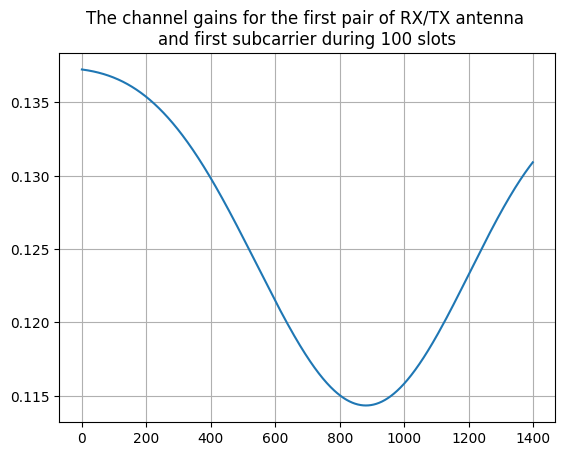

In [7]:
gs = np.concatenate([chanMat[:,0,0,0] for chanMat in chanMats])
plt.plot(np.abs(gs))
plt.title("The channel gains for the first pair of RX/TX antenna \n"+
          "and first subcarrier during 100 slots")
plt.grid()